Loading the Dataset

Price Optimization: Understanding the customers and their financial status will help to pace up with price optimization

In [1]:
#Lets import the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors

In [2]:
import datetime
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

In [4]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

In [5]:
palette = ["#a7e149","#e149a7", "#c393f4", "#d683f2", "#dd9e9e", "#fa91aa", "#fc9e9e", "#49e183", "#aa91aa", "#ff93f4"]

In [6]:
df=pd.read_csv("data_customersegmentation.csv",delimiter='\t')

In [7]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

Let's remove the outlier first:

In [8]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def summary(df):
    missing_info = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summary_df = pd.concat([missing_info, data_types], axis=1)

    for column in df.columns:    
        if pd.api.types.is_object_dtype(df[column]):#categorical column
            num_unique_choices = df[column].nunique()
            summary_df.loc[column, 'Categories'] = num_unique_choices
            
        if pd.api.types.is_numeric_dtype(df[column]):#getting low/up limit for numeric columns
            low_limit, up_limit = outlier_thresholds(df, column) 
            
            summary_df.loc[column,'min']=df[column].min()
            summary_df.loc[column,'max']=df[column].max()            
            summary_df.loc[column,'Mean']=df[column].mean()
            summary_df.loc[column,'Median']=df[column].median()
            summary_df.loc[column,'Variance']=df[column].var()
            summary_df.loc[column,'deviation']=df[column].std()

            num_outliers = len(df[(df[column] < low_limit) | (df[column] > up_limit)])
            summary_df.loc[column, 'Num Outliers'] = num_outliers
        

    return summary_df

summary(df)

,Missing Values,Data Type,min,max,Mean,Median,Variance,deviation,Num Outliers,Categories
ID,0,int64,0.0,11191.0,5592.159821,5458.5,1.054082e+07,3246.662198,0.0,NaN
Year_Birth,0,int64,1893.0,1996.0,1968.805804,1970.0,1.436179e+02,11.984069,1.0,NaN
Education,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
Marital_Status,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0
Income,24,float64,1730.0,666666.0,52247.251354,51381.5,6.336838e+08,25173.076661,3.0,NaN
Kidhome,0,int64,0.0,2.0,0.444196,0.0,2.898725e-01,0.538398,0.0,NaN
Teenhome,0,int64,0.0,2.0,0.506250,0.0,2.965219e-01,0.544538,0.0,NaN
Dt_Customer,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,663.0
Recency,0,int64,0.0,99.0,49.109375,49.0,8.388237e+02,28.962453,0.0,NaN
MntWines,0,int64,0.0,1493.0,303.935714,173.5,1.132978e+05,336.597393,27.0,NaN


In [9]:
print("Unique values of column 'Marital Status' are:",df["Marital_Status"].unique())
print("Unique values of column 'Education' are:",df["Education"].unique())

Unique values of column 'Marital Status' are: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
Unique values of column 'Education' are: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']


HANDLING MEMORY USAGE(Extra step)

In [10]:
def reducememoryusage(df:pd.DataFrame)->pd.DataFrame:
    start_mem=df.memory_usage().sum()/1024**2
    print("Memory usage of Data frame is {:.2f}MB".format(start_mem))
    for col in df.columns:
        col_type=df[col].dtype
        if col_type !=object:
            #picking up max and min values of those columns and checkign if they align with values of their data type range
            c_min=df[col].min()
            c_max=df[col].max()
            if str(col_type)[:3]=='int':
                if c_min>np.iinfo(np.int8).min and c_max<np.iinfo(np.int8).max:
                    df[col]=df[col].astype(np.int8)#converting the datatype
                elif c_min>np.iinfo(np.int16).min and c_max<np.iinfo(np.int16).max:
                    df[col]=df[col].astype(np.int16)
                elif c_min>np.iinfo(np.int32).min and c_max<np.iinfo(np.int32).max:
                    df[col]=df[col].astype(np.int32)
                elif c_min>np.iinfo(np.int64).min and c_max<np.iinfo(np.int64).max:
                    df[col]=df[col].astype(np.int64)
            else:
                if c_min>np.finfo(np.float32).min and c_max<np.finfo(np.float32).max:
                    df[col]=df[col].astype(np.float32)
                else:
                    df[col]=df[col].astype(np.float64)
    end_mem=df.memory_usage().sum()/1024**2
    print("Memory usage after optimization is: {:.2f}MB".format(end_mem))
    print("Memory usage decreased by: {:.1f}%".format(100*(start_mem-end_mem)/start_mem))
    return df
df=reducememoryusage(df)

Memory usage of Data frame is 0.50MB
Memory usage after optimization is: 0.13MB
Memory usage decreased by: 73.7%


DATA Cleaning

In [11]:
df=df.dropna()
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'],format="%d-%m-%Y")
df['Age']=2024-df["Year_Birth"]


df["Living Style"]=df["Marital_Status"].replace({"Married":"Partner","Together":"Partner","Absurd":"Alone","Widow":"Alone",
    "YOLO":"Alone","Divorced":"Alone","Single":"Alone",})# removing unnecessary classifications

df["Children"]=df["Kidhome"]+df["Teenhome"]
df["Family Size"]=df["Living Style"].replace({"Alone":1,"Partner":2})+df["Children"]

df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

In [12]:
df["Frequency"]=df["NumCatalogPurchases"]+df["NumDealsPurchases"]+df["NumStorePurchases"]+df["NumWebPurchases"]#Number of purchases ade by the customers

df["Monetary"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
del_cols = ["Marital_Status", "Z_CostContact", "Z_Revenue", 
            'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response',
           "MntWines","MntFruits","MntMeatProducts","MntFishProducts","MntSweetProducts","MntGoldProds",
           "NumDealsPurchases","NumWebPurchases","NumCatalogPurchases","NumStorePurchases", 'NumWebVisitsMonth',
           "Year_Birth", "Kidhome","Teenhome"] 
df =  df.drop(del_cols, axis=1)


Handling Outliers

In [13]:
numeric_columns = df.select_dtypes(include=['number']).columns
def outliers_boxplots(df,columns=numeric_columns,title="outlier numeric column",color="crimson"):
    fig=make_subplots(rows=1,cols=len(columns),subplot_titles=columns)

    for i,column in enumerate(columns):
        trace=go.Box(y=df[column],name=f'{column}',marker=dict(color=color))
        fig.add_trace(trace,row=1,col=i+1)
    fig.update_layout(title_text=title,title_x=0.5)
    fig.show()
outliers_boxplots(df)

In [14]:
df = df[df.Income<100000]
df = df[df.Age<80]
df = df[df.Monetary<1200]
df = df[df.Frequency<40]

In [15]:
outliers_boxplots(df, numeric_columns)

In [16]:
summary(df)

,Missing Values,Data Type,min,max,Mean,Median,Variance,deviation,Num Outliers,Categories
ID,0,int16,0.0,11191.0,5586.617284,5468.0,1.078642e+07,3284.268737,0.0,NaN
Education,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
Income,0,float32,1730.0,96547.0,45783.507812,44798.0,3.254052e+08,18038.990234,0.0,NaN
Dt_Customer,0,datetime64[ns],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recency,0,int8,0.0,99.0,48.648709,49.0,8.356059e+02,28.906849,0.0,NaN
Age,0,int16,28.0,79.0,54.789562,54.0,1.268995e+02,11.264970,0.0,NaN
Living Style,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
Children,0,int8,0.0,3.0,1.106061,1.0,4.968863e-01,0.704902,0.0,NaN
Family Size,0,int64,1.0,5.0,2.760943,3.0,7.378785e-01,0.858999,0.0,NaN
Frequency,0,int8,0.0,39.0,13.284512,12.0,5.337493e+01,7.305815,0.0,NaN


so now we dont have any outliers in any column, so we are done with preprocessing steps so lets beign with clustering

In [17]:
import scipy.stats as stats

A chi-square test is a statistical hypothesis test that determines if two categorical variables are independent in influencing the test statistic. It's also known as the chi-square test of independence, or Pearson's chi-square test. This test is used when the sample sizes are large, and it's often useful for testing hypotheses when the variables are nominal, like in clinical research

If the calculated value is greater than the critical value, you reject the null hypothesis. If the calculated value is less than the critical value, you fail to reject the null hypothesis.

In [18]:
contingency_table=pd.crosstab(df['Education'],df['Living Style'])#here living style is basically living alone or together in family

chi2,p,g,h=stats.chi2_contingency(contingency_table)
print(f'Chi-squared statistic: {chi2}')
print(f'P-value: {p}')

Chi-squared statistic: 2.2303663792700914
P-value: 0.327855213721148


In [19]:
fig=px.bar(contingency_table,x=contingency_table.index,y=contingency_table.columns,title=f'Chi-Square test:P-value={p:.4f}',labels={'x':'Education','y':"Living Style"},barmode='group')
fig.show()

The Chi-square statistic increases as the observed frequencies in the contingency table deviate from the expected frequencies (assuming no relationship)

A high p-value (generally above 0.05) suggests that the observed difference between the observed and expected frequencies could be due to chance, and we fail to reject the null hypothesis (no association between education and living style).

In [20]:
LE=LabelEncoder()
object_cols =["Education","Living Style"]
for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)
print('All features are now numerical')
df.head()

All features are now numerical


,ID,Education,Income,Dt_Customer,Recency,Age,Living Style,Children,Family Size,Frequency,Monetary
1,2174,0,46344.0,2014-03-08,38,70,0,2,3,6,27
2,4141,0,71613.0,2013-08-21,26,59,1,0,2,21,776
3,6182,0,26646.0,2014-02-10,26,40,1,1,3,8,53
4,5324,1,58293.0,2014-01-19,94,43,1,1,3,19,422
5,7446,1,62513.0,2013-09-09,16,57,1,1,3,22,716


In [21]:
df.columns

Index(['ID', 'Education', 'Income', 'Dt_Customer', 'Recency', 'Age',
       'Living Style', 'Children', 'Family Size', 'Frequency', 'Monetary'],
      dtype='object')

In [22]:
df_clustering=df[["Education","Income","Age", "Recency","Family Size","Monetary","Frequency"]]
#Scaling
scaler = StandardScaler()
scaler.fit(df_clustering)
scaled_features = pd.DataFrame(scaler.transform(df_clustering),columns= df_clustering.columns )
print('All features are now scalled')
scaled_features.head()

All features are now scalled


,Education,Income,Age,Recency,Family Size,Monetary,Frequency
0,-0.889511,0.031080,1.350621,-0.368484,0.278376,-0.928418,-0.997364
1,-0.889511,1.432272,0.373869,-0.783727,-0.886097,1.076258,1.056371
2,-0.889511,-1.061194,-1.313249,-0.783727,0.278376,-0.858830,-0.723533
3,0.543680,0.693664,-1.046862,1.569317,0.278376,0.128788,0.782540
4,0.543680,0.927668,0.196277,-1.129763,0.278376,0.915670,1.193287


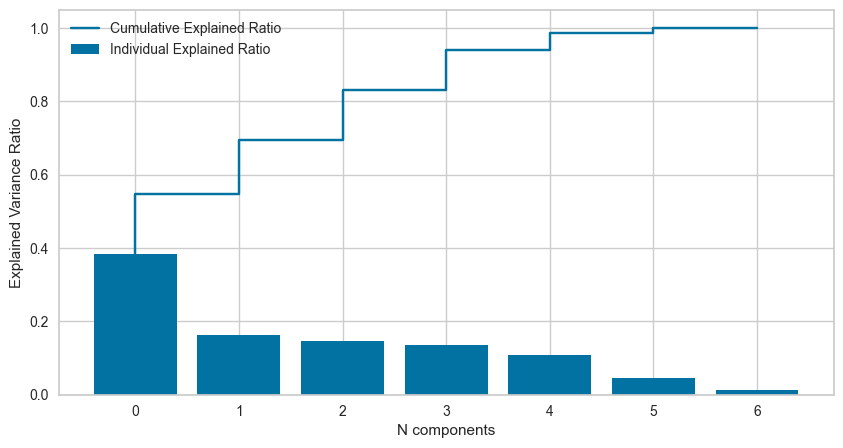

In [23]:
pca = PCA()
pca.fit(scaled_features)
cum_sum_eigenvalues = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10,5))
plt.bar(range(0, len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, label="Individual Explained Ratio")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, label="Cumulative Explained Ratio")
plt.xlabel("N components")
plt.ylabel("Explained Variance Ratio")
plt.legend(loc="best")
plt.show()

The first 3 components have slightly more than 80% of the informations

In [24]:
cols = ["PCA1", "PCA2", "PCA3"]
pca = PCA(n_components=len(cols))
pca.fit(scaled_features)
PCA_df = pd.DataFrame(pca.transform(scaled_features), columns=(cols))
PCA_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PCA1,1782.0,1.993666e-18,1.641395,-2.763695,-1.436885,-0.363463,1.487221,3.813923
PCA2,1782.0,7.974666e-18,1.069990,-3.040621,-0.669513,-0.046590,0.721332,3.198541
PCA3,1782.0,-4.984166e-17,1.012709,-2.365613,-0.710949,-0.014540,0.711622,2.526006


Elbow Method

The Elbow Method is a technique used to **determine** the optimal number of clusters in a dataset for algorithms like K-Means. * It involves running the clustering algorithm with different numbers of clusters (e.g., 1 to K) and calculating the cost function (usually within-cluster sum of squares, or WCSS) for each value of K. * As the number of clusters increases, the WCSS generally decreases, because more clusters mean that data points are closer to their cluster centers. However, adding more clusters eventually leads to diminishing returns. The Elbow Method looks for an "elbow" point in the plot of WCSS against the number of clusters. The elbow point is where the rate of decrease in WCSS sharply changes, and it indicates the optimal number of clusters.

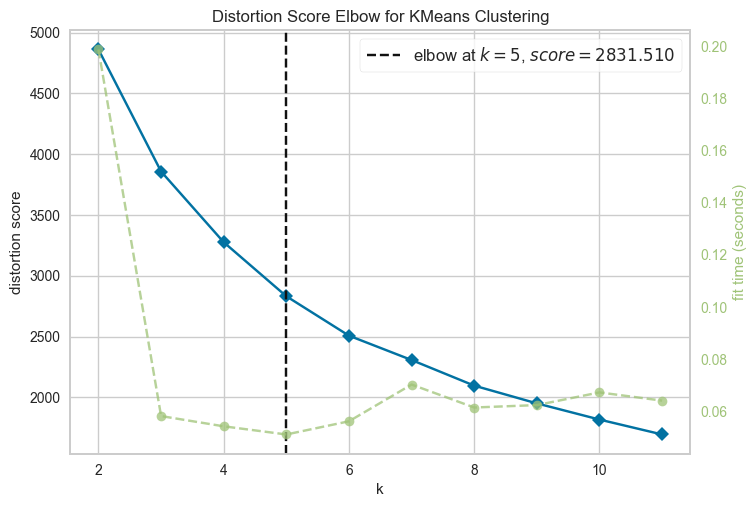

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=11)
visualizer.fit(PCA_df)        # Fit the data to the visualizer
visualizer.show() 

Silhouette score

The silhouette score is a metric used to measure the quality of clusters in unsupervised learning. It quantifies how similar each data point in one cluster is to other data points in the same cluster compared to the nearest neighboring cluster. * The silhouette score helps evaluate the appropriateness of clustering solutions. Higher silhouette scores indicate better-defined clusters, helping to determine the optimal number of clusters in clustering algorithms like K-Means. RMF Metric (Recency, Frequency, Monetary)

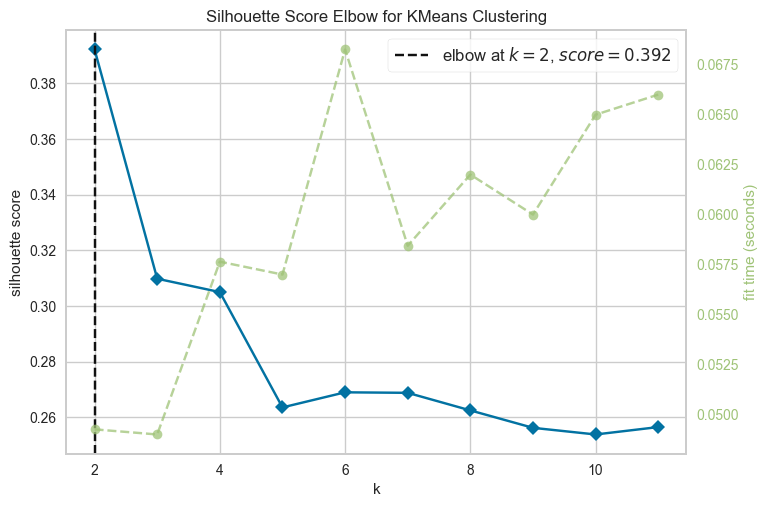

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [26]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=11, metric='silhouette')
visualizer.fit(PCA_df)        # Fit the data to the visualizer
visualizer.show()

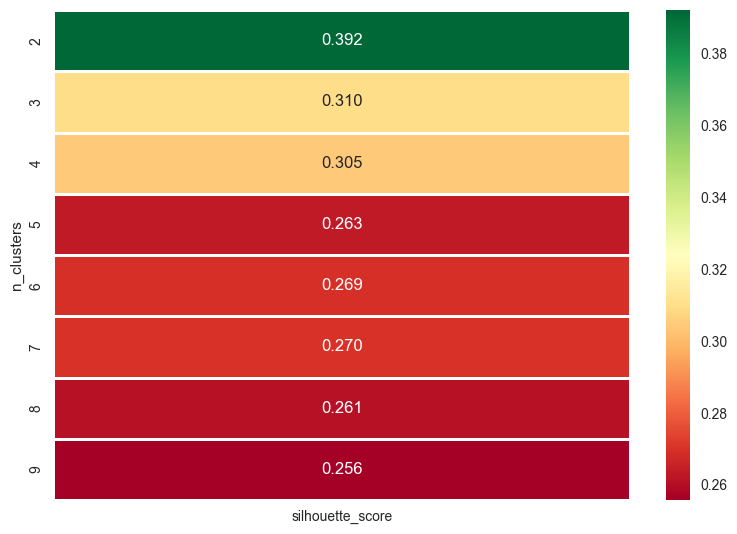

In [27]:
from sklearn.metrics import silhouette_score
def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='RdYlGn')
    plt.tight_layout()
    plt.show()
    
visualize_silhouette_layer(PCA_df)

In [28]:
nb_clusters = visualizer.elbow_value_
AC = AgglomerativeClustering(n_clusters=3)#nb_clusters

# fit model and predict clusters
AC_df = AC.fit_predict(PCA_df)
PCA_df["Clusters"] = AC_df
PCA_df["Family Size"] = df["Family Size"]
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= AC_df

In [29]:
PCA_df.head()

,PCA1,PCA2,PCA3,Clusters,Family Size
0,-0.735988,1.215247,-0.020909,2,NaN
1,2.251372,-0.507874,0.033121,0,3.0
2,-1.710424,-0.547919,-0.234194,1,2.0
3,0.563663,-0.211053,-0.932998,0,3.0
4,1.650149,-0.018853,1.311942,0,3.0


Visualizing clusters


In [30]:
from plotly.colors import qualitative

In [31]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot, plot
x =PCA_df["PCA1"]
y =PCA_df["PCA2"]
z =PCA_df["PCA3"]
c =PCA_df["Clusters"]
trace1 = go.Scatter3d(x=x,y=y,z=z,mode='markers',marker=dict(size=6, color=c, colorscale=palette, colorbar=dict(title='Clusters')))
data = [trace1]
layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [32]:
# Create a countplot using Plotly Express
fig = px.histogram(data_frame=df, x="Clusters",nbins=7)

# Update the layout and title
fig.update_layout(title="Distribution Of The Clusters")
fig.update_xaxes(title_text="Clusters")
fig.update_yaxes(title_text="Count")

# Show the plot
fig.show()

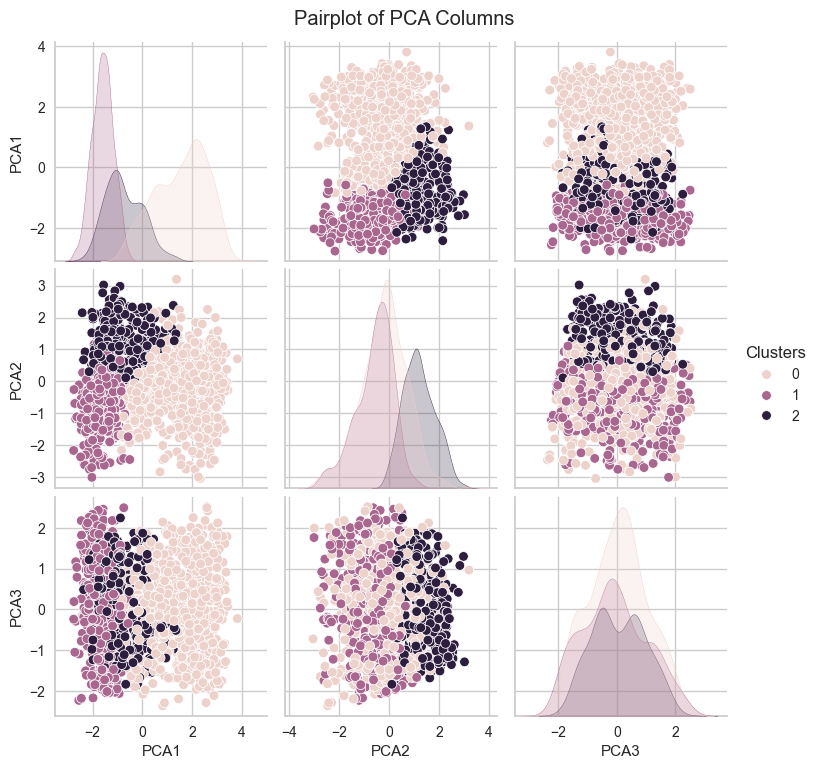

In [33]:
sns.pairplot(data=PCA_df, vars=['PCA1', 'PCA2', 'PCA3'], hue='Clusters')
plt.suptitle("Pairplot of PCA Columns", y=1.02)
plt.show()

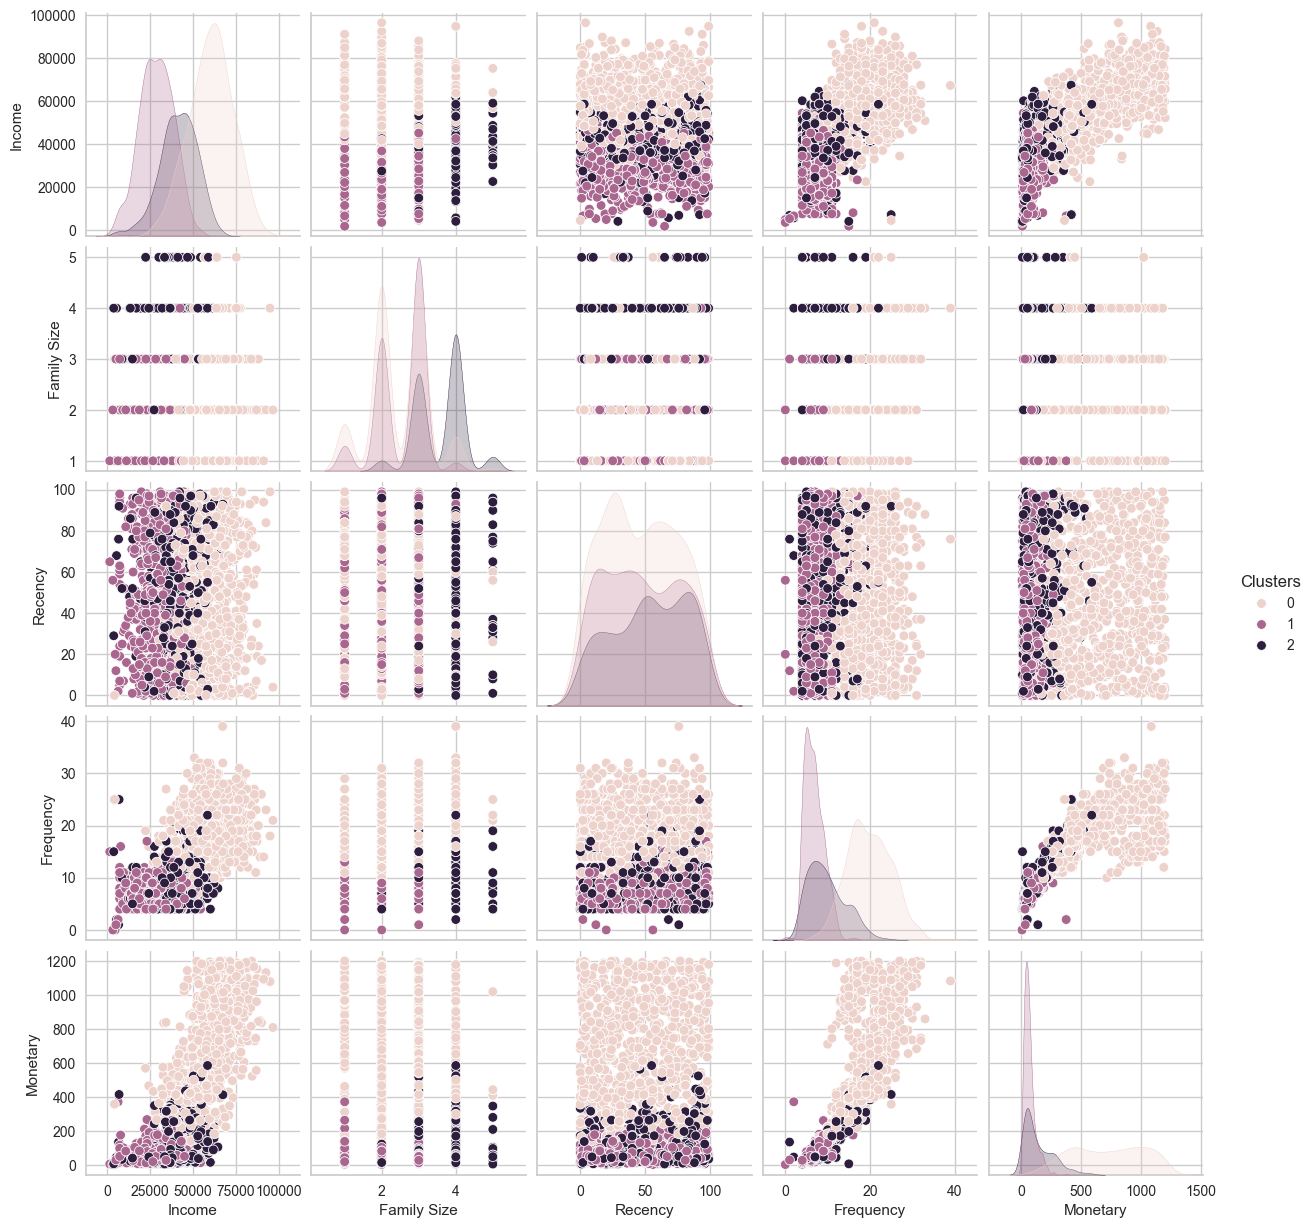

In [34]:
sns.pairplot(df[["Clusters","Income","Family Size","Recency", "Frequency", "Monetary"]],hue= "Clusters")
plt.show()

In [35]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
columns = ["Income", "Age", "Family Size", "Recency", "Frequency", "Monetary"]
fig = make_subplots(rows=2, cols=3, subplot_titles=[f'Clusters vs. {column}' for column in columns], horizontal_spacing=0.15)

for i, column in enumerate(columns):
    row = i // 3 + 1
    col = i % 3 + 1
    trace = go.Box(y=df[column], x=df["Clusters"], name=f'Clusters vs. {column}', )
    fig.add_trace(trace, row=row, col=col)
fig.update_layout(
    showlegend=False,
    height=800,
    title_text="Clusters vs. Numeric Columns",
)
fig.show()

In [36]:
import plotly.express as px
fig = px.scatter(df, x='Income', y='Monetary', color='Clusters', 
                 size='Family Size',size_max=16)
fig.update_layout(
    xaxis_title='Income', yaxis_title='Total Spendings',
    xaxis=dict(title=dict(text='Income', font=dict(size=20))),
    yaxis=dict(title=dict(text='Total Spendings', font=dict(size=20))))
fig.show()

In [37]:
means = df.groupby(['Clusters']).agg({'Family Size': 'mean','Income': 'mean','Age': 'mean','Recency': 'mean','Frequency': 'mean','Monetary': 'mean'})
counts = df['Clusters'].value_counts().reset_index()
counts.columns = ['Clusters', 'Count']
result = pd.merge(means, counts, on='Clusters')
result

,Clusters,Family Size,Income,Age,Recency,Frequency,Monetary,Count
0,0,2.481108,60311.031250,56.824937,46.711587,19.788413,718.105793,794
1,1,2.539405,28754.517578,46.989492,47.980736,6.798599,65.971979,571
2,2,3.597122,41439.851562,61.594724,53.251799,9.781775,140.074341,417


Cluster 0:
- Total member of this cluster is 794
- Compared to other clusters, they have high income and high spent.
- age is between 50 to 60

Cluster 1:
- Total member of this cluster is 571
- Compared to other clusters, they have low Income and low spending.
- age is between 40 to 50

Cluster 2:
- Total member of this cluster is 417
- Compared to other clusters, they have avg Income and avg spending.
- age is between 55 to 65


Lets begin with behavioural analysis 

RMF Metric (Recency, Frequency, Monetary)

 RMF Metric (Recency, Frequency, Monetary): is a customer segmentation and analysis method used in marketing and customer relationship management. It stands for Recency, Frequency, and Monetary Value, and it involves segmenting customers based on these three dimensions

In [38]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}# regex mapping

- Hibernating: Customers who have low recency (1-2) and low frequency (1-2).
- At_Risk: Customers with low recency (1-2) and moderate frequency (3-4).
- Cant_loose: Customers with low recency (1-2) and high frequency (5).
- About_to_sleep: Customers with moderate recency (3) and low frequency (1-2).
- Need_attention: Customers with moderate recency (3) and moderate frequency (3).
- Loyal_customers: Customers with moderate recency (3-4) and high frequency (4-5).
- Promising: Customers with moderate recency (4) and low frequency (1).
- New_customers: Customers with high recency (5) and low frequency (1).
- Potential_loyalists: Customers with high recency (4-5) and moderate frequency (2-3).
- Champions: Customers with high recency (5) and high frequency (4-5).

In [39]:
def get_rfm_scores(dataframe):
    dataframe["R"]=pd.qcut(dataframe["Recency"], 5, labels=[5, 4, 3, 2, 1])
    dataframe["F"]=pd.qcut(dataframe["Frequency"].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
    dataframe["M"]=pd.qcut(dataframe["Monetary"], 5, labels=[1, 2, 3, 4, 5])
    dataframe["RFM_SCORE"]=dataframe["R"].astype(str) + dataframe["F"].astype(str) # + dataframe["M"].astype(str) 
    return dataframe
get_rfm_scores(df)
df.reset_index()
df['segment']=df['RFM_SCORE'].replace(seg_map, regex = True)
df.head()

,ID,Education,Income,Dt_Customer,Recency,Age,Living Style,Children,Family Size,Frequency,Monetary,Clusters,R,F,M,RFM_SCORE,segment
1,2174,0,46344.0,2014-03-08,38,70,0,2,3,6,27,2,4,1,1,41,promising
2,4141,0,71613.0,2013-08-21,26,59,1,0,2,21,776,0,4,5,4,45,loyal_customers
3,6182,0,26646.0,2014-02-10,26,40,1,1,3,8,53,1,4,2,2,42,potential_loyalists
4,5324,1,58293.0,2014-01-19,94,43,1,1,3,19,422,0,1,4,4,14,at_Risk
5,7446,1,62513.0,2013-09-09,16,57,1,1,3,22,716,0,5,5,4,55,champions


In [40]:
x=df.segment.value_counts()
fig=px.treemap(x,path=[x.index],values=x,color=x.index,color_discrete_map={x.index[i]:palette[i%len(palette)]for i in range(len(x.index))})
fig.update_layout(title_text='Distribution of the RFM Segments',title_x=0.5,title_font=dict(size=20))
fig.update_traces(textinfo="label+value+percent root")
fig.show()

In [41]:
grouped=df.groupby(['Clusters','segment']).size().reset_index(name='Count')

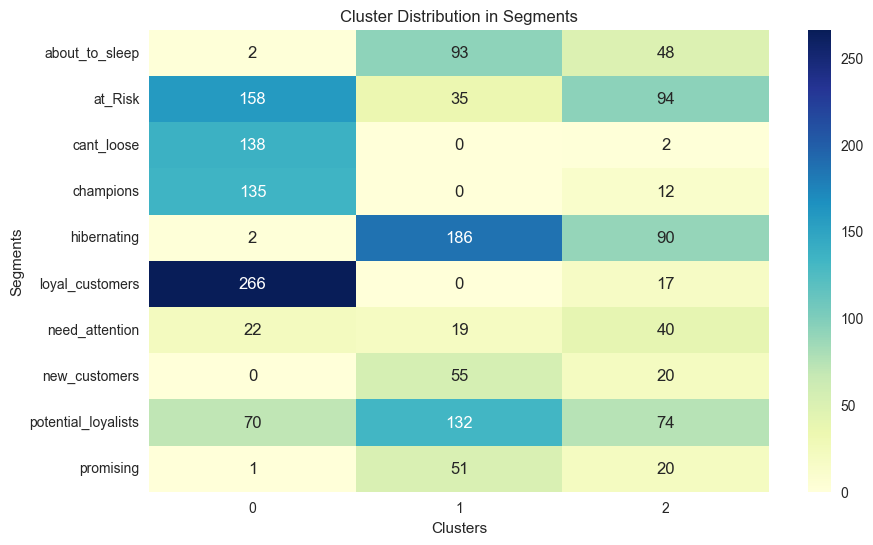

In [42]:
pivot_table = grouped.pivot(index='segment',columns='Clusters', values='Count').fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='g', cbar=True)
plt.xlabel('Clusters')
plt.ylabel('Segments')
plt.title('Cluster Distribution in Segments')
plt.show()

- Cluster 0 :
- - Total member of this cluster is 826
- - Compared to other clusters, they have high income and high spent.
- - Their Family Size is between 2 and 4 people.
- - Their Age is between 40 and 60 years.

- Cluster 1 :
- - Total member of this cluster is 694
- - Compared to other clusters, they have low Income and low spending.
- - Their Family Size is between 2 and 3 people.
- - Their Age is between 30 and 50 years.

- Cluster 2 :
- - Total member of this cluster is 271
- - Compared to other clusters, they have avg Income and avg spending
- - Their Family Size is between 3 and 5 people.
- - Their Age is between 55 and 60 years.

In [43]:
grouped = df.groupby(['Clusters','segment']).size().reset_index(name='Count')
pivot_table = grouped.pivot(index='segment', columns='Clusters', values='Count').fillna(0)
fig = px.bar(pivot_table, x=pivot_table.index, y=pivot_table.columns, title='Stacked Bar Plot', labels={'x': 'Clusters', 'y': 'Count'},color_discrete_sequence=palette)
fig.show()

In [44]:
grouped = df.groupby(['Clusters', 'segment']).size().reset_index(name='Count')
pivot_table = grouped.pivot(index='Clusters', columns='segment', values='Count').fillna(0)
fig = px.bar(pivot_table, x=pivot_table.index, y=pivot_table.columns,title='Clusters segments count',labels={'index':'Clusters','value':'Count'},color_discrete_sequence=palette)

In [45]:
fig.show()

- Cluster 0 -
-826<br>
-Between 40 and 60 years<br>
-high income high avg spending<br>
-Between 2 and 4 people -<br>
- Is characterized by a high number of "loyal_customers" (260) and "at_Risk" customers (196). It also has "champions," "potential_loyalists," "cant_loose," and "need_attention" segments.
- Is dominated by "loyal_customers," which are the most valuable customers. It's crucial to maintain and nurture these customers. "at_Risk" customers also need attention, as they are in danger of leaving.
- Consider implementing customer loyalty programs to retain "loyal_customers." For "at_Risk" customers, create campaigns to address their concerns and keep them engaged.
- Monitor the "promising" customers in Cluster 0 and Cluster 1 to see if their behavior evolves positively, and consider offering incentives to encourage repeat purchases.

- Cluster 1 -
-694<br>
-Between 30 and 50 years<br>
-low income and low spent<br>
-Between 2 and 3 people -<br>
- This cluster has a diverse range of segments, with a significant number of "hibernating" customers (331) and "potential_loyalists" (241). It also includes customers in the "about_to_sleep," "at_Risk," "champions," "loyal_customers," "need_attention," "new_customers," and "promising" segments.
- Has a mix of different customer segments, including both potential loyal customers and those who require attention. It's essential to focus on retaining "potential_loyalists" and re-engaging "hibernating" customers.
- For "hibernating" customers, consider implementing re-engagement strategies, such as special offers or personalized recommendations, to bring them back to active purchasing.
- For the "new_customers", provide a great onboarding experience to convert them into loyal customers in the future.

- Cluster 2 -
-271<br>
-Between 55 and 60 years<br>
-Average income Average high spending<br>
-Between 3 and 5 people -<br>
- Has a smaller number of segments, including "at_Risk," "cant_loose," "champions," "loyal_customers," "need_attention," and "potential_loyalists."
- Seems to have fewer customers, but it's worth focusing on the "loyal_customers" and identifying opportunities for growth within this segment.
- Work on understanding the needs and preferences of "loyal_customers" to further strengthen their loyalty. Also, explore ways to convert "cant_loose," "champions," and "potential_loyalists" into long-term loyal customers.

In [46]:
df.head()

,ID,Education,Income,Dt_Customer,Recency,Age,Living Style,Children,Family Size,Frequency,Monetary,Clusters,R,F,M,RFM_SCORE,segment
1,2174,0,46344.0,2014-03-08,38,70,0,2,3,6,27,2,4,1,1,41,promising
2,4141,0,71613.0,2013-08-21,26,59,1,0,2,21,776,0,4,5,4,45,loyal_customers
3,6182,0,26646.0,2014-02-10,26,40,1,1,3,8,53,1,4,2,2,42,potential_loyalists
4,5324,1,58293.0,2014-01-19,94,43,1,1,3,19,422,0,1,4,4,14,at_Risk
5,7446,1,62513.0,2013-09-09,16,57,1,1,3,22,716,0,5,5,4,55,champions


In [47]:
df.to_csv('final CSV.csv', index=False)  # Save to 'my_data.csv' without row index